# K‑Fold Model Comparison Dashboard

*Generated: 2025-08-19 15:37*

This notebook loads k‑fold training histories for **multiple models**, extracts the **best epoch per fold** (based on `val_accuracy` by default), and provides **publication‑quality** comparisons:

- Summary tables per model and combined
- Boxplot of validation accuracy across folds (per model)
- Mean±SD bar charts for validation accuracy and overfitting gap
- CSV export of all summarized results

> **Assumptions:** Each fold's history is stored as a NumPy `.npy` (dict-like) with keys at least: `accuracy`, `loss`, `val_accuracy`, `val_loss`. Filenames contain `fold_{i}` so the fold number can be parsed.


In [11]:

import glob
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", "{:.4f}".format)


## 1) Configure your models and file patterns

Edit the dictionary below so that each **key** is a human‑readable model name and each **value** is a **glob pattern** that matches all fold history files for that model.

**Examples**
- `"/home/lennart/work/logs/ModelA/fold_*/*history.npy"`
- `"/home/lennart/work/logs/ResNet/kfold_*/*.npy"`

> The pattern must include `fold_` followed by a number (e.g., `fold_1`), which is used to map results to each fold.


In [12]:

# === EDIT ME: map model names to their glob patterns ===
MODEL_PATTERNS = {
    "Baseline Conv": '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/control_conv/2_classes_training/control_conv/conv_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_07_30_14_14_03/history_conv_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_07_30_14_14_03.npy',
    "ResNet34": "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNet34/2_classes_training/control/resnet34_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_07_30_19_52_45/history_resnet34_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_07_30_19_52_45.npy",
    "ResNeXt50": '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNeXt50/2_classes_training/control/resnext50_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_07_31_12_48_20/history_resnext50_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_07_31_12_48_20.npy',
    "ResNeXt101": "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNeXt101/2_classes_training/control/resnext101_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_08_01_14_38_29/history_resnext101_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_08_01_14_38_29.npy",
    "ResNet152": '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNet152/2_classes_training/control/resnet152_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_08_17_19_31_38/history_resnet152_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_08_17_19_31_38.npy'
}

# Metric used to pick the best epoch within each fold
SELECTION_METRIC = "val_accuracy"  # change to "val_loss" if desired
HIGHER_IS_BETTER = True            # set False if using "val_loss" or any metric where lower is better


## 2) Helpers: load and summarize each model

In [13]:

def _extract_fold_number(path: str):
    m = re.search(r"fold_(\d+)", str(path))
    return int(m.group(1)) if m else None


def summarize_single_model(path_pattern: str,
                           selection_metric: str = "val_accuracy",
                           higher_is_better: bool = True) -> pd.DataFrame:
    """Load all fold histories for one model and summarize at the best epoch per fold."""
    files = sorted(glob.glob(path_pattern))
    rows = []
    for f in files:
        fold_num = _extract_fold_number(f)
        if fold_num is None:
            continue

        try:
            history = np.load(f, allow_pickle=True).item()
            df = pd.DataFrame(history)

            if selection_metric not in df.columns:
                print(f"[WARN] {selection_metric} not found in {f}. Skipping.")
                continue

            if higher_is_better:
                best_idx = df[selection_metric].idxmax()
            else:
                best_idx = df[selection_metric].idxmin()

            row = {
                "Fold": fold_num,
                "Best Epoch": int(best_idx) + 1,
                "Val Accuracy": float(df.get("val_accuracy", pd.Series([np.nan])).iloc[best_idx]),
                "Val Loss": float(df.get("val_loss", pd.Series([np.nan])).iloc[best_idx]),
                "Train Accuracy": float(df.get("accuracy", pd.Series([np.nan])).iloc[best_idx]),
                "Train Loss": float(df.get("loss", pd.Series([np.nan])).iloc[best_idx]),
            }
            row["Overfitting Gap (Acc)"] = row["Train Accuracy"] - row["Val Accuracy"]
            rows.append(row)
        except Exception as e:
            print(f"[ERROR] Could not process {f}: {e}")

    if not rows:
        return pd.DataFrame(columns=[
            "Fold", "Best Epoch", "Val Accuracy", "Val Loss", "Train Accuracy", "Train Loss", "Overfitting Gap (Acc)"
        ])

    out = pd.DataFrame(rows).sort_values("Fold").reset_index(drop=True)
    return out


def summarize_all_models(model_patterns: dict,
                         selection_metric: str = "val_accuracy",
                         higher_is_better: bool = True):
    """Return two DataFrames:
       - per_model_results: dict of model_name -> fold-wise summary DataFrame
       - combined: one DataFrame with a 'Model' column added
    """
    per_model = {}
    combined_rows = []
    for model_name, pattern in model_patterns.items():
        df = summarize_single_model(pattern, selection_metric, higher_is_better)
        per_model[model_name] = df
        if len(df):
            tmp = df.copy()
            tmp.insert(0, "Model", model_name)
            combined_rows.append(tmp)

    combined = pd.concat(combined_rows, ignore_index=True) if combined_rows else pd.DataFrame()
    return per_model, combined


## 3) Run the summary

In [14]:

per_model_results, combined = summarize_all_models(
    MODEL_PATTERNS,
    selection_metric=SELECTION_METRIC,
    higher_is_better=HIGHER_IS_BETTER
)

if combined.empty:
    print("No results found. Please check your MODEL_PATTERNS and file paths.")
else:
    display(combined.sort_values(["Model", "Fold"]).reset_index(drop=True))
    print("\nPer-model descriptive stats (Val Accuracy):\n")
    for name, df in per_model_results.items():
        if df.empty:
            print(f"- {name}: no data")
            continue
        desc = df["Val Accuracy"].describe()[["count","mean","std","min","max"]]
        print(f"\n{name}\n{desc}")


,Model,Fold,Best Epoch,Val Accuracy,Val Loss,Train Accuracy,Train Loss,Overfitting Gap (Acc)
0,Baseline Conv,0,15,0.6031,0.9931,0.4854,1.0439,-0.1177
1,Baseline Conv,1,298,0.7069,0.9749,0.7033,0.8651,-0.0036
2,Baseline Conv,2,329,0.7377,1.0586,0.7193,0.8406,-0.0184
3,Baseline Conv,3,30,0.8172,0.9201,0.5040,1.0273,-0.3132
4,Baseline Conv,4,692,0.6693,1.3071,0.8923,0.5505,0.2230
5,Baseline Conv,5,477,0.7722,0.8422,0.8254,0.6759,0.0532
6,Baseline Conv,6,143,0.7778,0.8754,0.6204,0.9560,-0.1574
7,Baseline Conv,7,218,0.7315,0.8801,0.6513,0.9264,-0.0802
8,Baseline Conv,8,258,0.7143,1.2212,0.6621,0.9258,-0.0522
9,Baseline Conv,9,5,0.7089,0.9708,0.4934,1.1386,-0.2155



Per-model descriptive stats (Val Accuracy):


Baseline Conv
count   10.0000
mean     0.7239
std      0.0600
min      0.6031
max      0.8172
Name: Val Accuracy, dtype: float64

ResNet34
count   10.0000
mean     0.7281
std      0.0448
min      0.6457
max      0.7957
Name: Val Accuracy, dtype: float64

ResNeXt50
count   10.0000
mean     0.7566
std      0.0266
min      0.7252
max      0.7929
Name: Val Accuracy, dtype: float64

ResNeXt101
count   10.0000
mean     0.7432
std      0.0289
min      0.7023
max      0.7957
Name: Val Accuracy, dtype: float64

ResNet152
count   10.0000
mean     0.7480
std      0.0315
min      0.7008
max      0.8011
Name: Val Accuracy, dtype: float64


## 4) Boxplot: Validation Accuracy across folds (per model)

This figure shows the **distribution** of validation accuracies across folds for each model. Use it to visually compare model stability and central tendency.


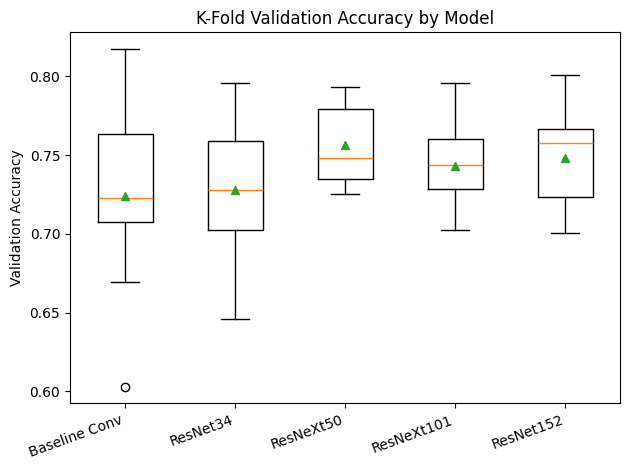

In [15]:

if not combined.empty:
    models = list(per_model_results.keys())
    data = [per_model_results[m]["Val Accuracy"].dropna().values for m in models if not per_model_results[m].empty]

    plt.figure()
    plt.boxplot(data, showmeans=True)
    plt.xticks(range(1, len(models) + 1), models, rotation=20, ha="right")
    plt.ylabel("Validation Accuracy")
    plt.title("K-Fold Validation Accuracy by Model")
    plt.tight_layout()
    plt.show()


## 5) Mean ± SD: Validation Accuracy

Bars show the mean validation accuracy per model with standard‑deviation error bars (across folds).

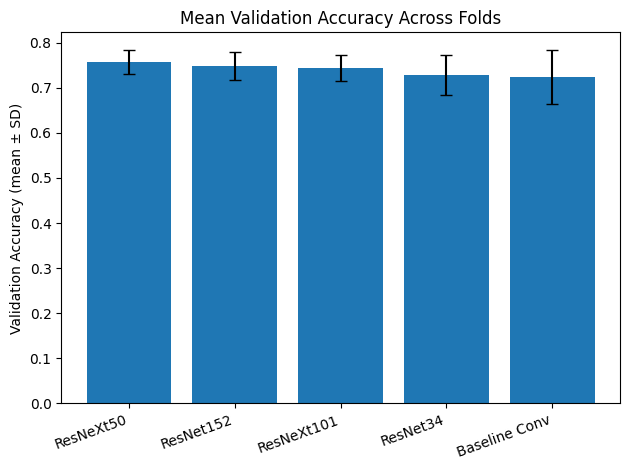

,mean,std
Model,,
ResNeXt50,0.7566,0.0266
ResNet152,0.7480,0.0315
ResNeXt101,0.7432,0.0289
ResNet34,0.7281,0.0448
Baseline Conv,0.7239,0.0600


In [16]:

if not combined.empty:
    summary = (combined
               .groupby("Model")["Val Accuracy"]
               .agg(["mean","std"])
               .sort_values("mean", ascending=False))

    plt.figure()
    plt.bar(summary.index, summary["mean"], yerr=summary["std"], capsize=4)
    plt.ylabel("Validation Accuracy (mean ± SD)")
    plt.title("Mean Validation Accuracy Across Folds")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

    display(summary)


## 6) Mean ± SD: Overfitting Gap (Train Acc − Val Acc)

Positive values indicate the model fits training data better than validation (**overfitting**).

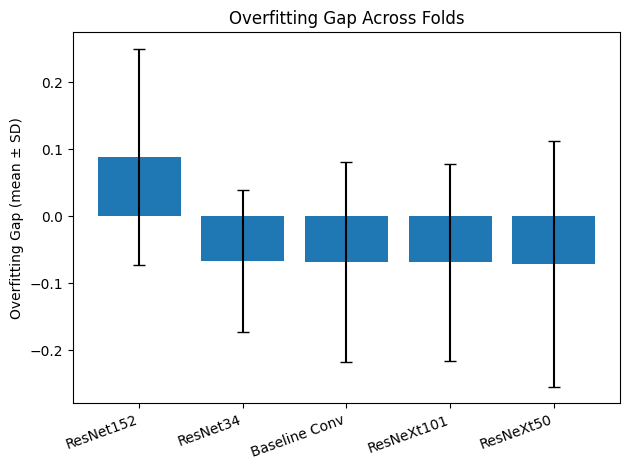

,mean,std
Model,,
ResNet152,0.0882,0.1609
ResNet34,-0.0662,0.1057
Baseline Conv,-0.0682,0.1486
ResNeXt101,-0.0686,0.1471
ResNeXt50,-0.0713,0.1828


In [17]:

if not combined.empty:
    gap = (combined
           .groupby("Model")["Overfitting Gap (Acc)"]
           .agg(["mean","std"])
           .sort_values("mean", ascending=False))

    plt.figure()
    plt.bar(gap.index, gap["mean"], yerr=gap["std"], capsize=4)
    plt.ylabel("Overfitting Gap (mean ± SD)")
    plt.title("Overfitting Gap Across Folds")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

    display(gap)


## 7) Export combined summary to CSV

In [18]:

if not combined.empty:
    out_path = Path("kfold_combined_summary.csv").resolve()
    combined.to_csv(out_path, index=False)
    print(f"Saved combined summary to: {out_path}")


Saved combined summary to: /Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification/notebooks/AI/kfold_combined_summary.csv


---

### Notes
- Replace `MODEL_PATTERNS` with the appropriate paths for your project.
- If your model selection should be based on **minimum validation loss**, set:
  ```python
  SELECTION_METRIC = "val_loss"
  HIGHER_IS_BETTER = False
  ```
- Ensure your history files contain the necessary keys. If not, adapt the code accordingly.
- Each plot uses **matplotlib** only, with one chart per figure and default styling (no custom colors), to be compatible with strict pipelines.
